# Examples and Applications

## Problem definitions

Imagine that we want to use a variational algorithm to find the eigenvalue of the following oberservable:
$$\hat O_1 = 2II - 2XX + 3YY - 3ZZ$$
This observable has the following eigenvalues:
$$
\begin{Bmatrix}
    \lambda_0 = -6 \\
    \lambda_1 = 4 \\
    \lambda_2 = 4 \\
    \lambda_3 = 6
\end{Bmatrix}
$$
And eigenstates:
$$


\begin{Bmatrix}
    |\psi_0\rangle = \frac{1}{\sqrt2}(|00\rangle + |11\rangle) \\
    |\psi_1\rangle = \frac{1}{\sqrt2}(|00\rangle - |11\rangle) \\
    |\psi_2\rangle = \frac{1}{\sqrt2}(|01\rangle - |10\rangle) \\
    |\psi_3\rangle = \frac{1}{\sqrt2}(|01\rangle + |10\rangle)
\end{Bmatrix}
$$

In [6]:
from dotenv import load_dotenv
from os import getenv

load_dotenv()
token = getenv('IBM_TOKEN')

In [1]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

## Custom VQE

We'll first explore how to construct a VQE instance manually to find the lowest eigenvalue for $\hat O_1$. This will incorporate a variety of techniques that we have covered throughout this course.

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session


def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

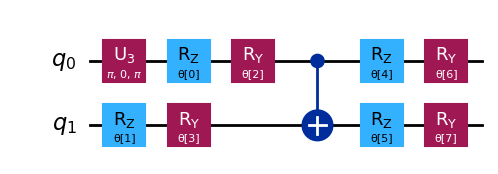

In [4]:
import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl', style='iqp')

In [7]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

We now set an initial set of parameters:

In [8]:
import numpy as np

x0 = np.ones(8)

We can minimize this cost function to calculate optimal parameters

In [9]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [10]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.9985
       x: [ 1.875e+00  6.943e-01  1.575e+00  2.094e-03  2.317e+00
            8.134e-01  8.333e-01  8.102e-01]
    nfev: 85
   maxcv: 0.0

In [13]:
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

experimental_min_eigenvalue = cost_func_vqe(result.x, ansatz, observable_1, estimator)

print(
    f"Percent error: {abs((experimental_min_eigenvalue - solution_eigenvalue) / solution_eigenvalue):.2e}"
)

Number of iterations: 85
Time (s): 907.8338372707367
Percent error: 2.50e-04


As you can see the result is extremely close to the ideal.

## Experimenting to improve speed and accuracy

### Add reference state

In the previous example we have not used any reference operator $U_R$. Now let us think about how the ideal eigenstate $\frac{1}{\sqrt2(|00\rangle+|11\rangle)$ can be obtained. Consider the following circuit: 

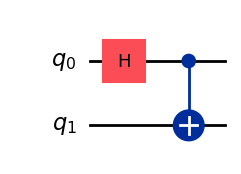

In [15]:
from qiskit import QuantumCircuit

ideal_qc = QuantumCircuit(2)
ideal_qc.h(0)
ideal_qc.cx(0, 1)

ideal_qc.draw("mpl", style="iqp")

In [16]:
from qiskit.quantum_info import Statevector

Statevector(ideal_qc)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


Now that we have seen how a circuit preparing the solution state looks like, it seems reasonable to use a Hadamard gate as a reference circuit, so that the full ansatz becomes:

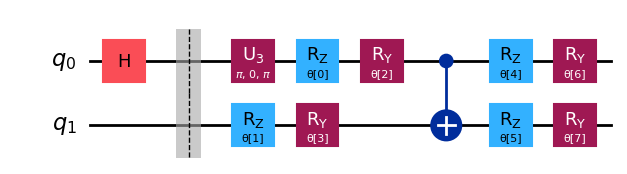

In [18]:
reference = QuantumCircuit(2)
reference.h(0)
# Include barrier to separate reference from variational form
reference.barrier()

ref_ansatz = ansatz.decompose().compose(reference, front=True)

ref_ansatz.draw("mpl", style="iqp")

For this new circuit, the ideal solution could be reached with all the parameters set to $0$, so this confirms that the choice of reference circuit is reasonable.

Now let us compare the number of cost function evaluations, optimizer iterations and time taken with those of the previous attempt.

In [19]:
import time

start_time = time.time()

ref_result = minimize(cost_func_vqe, x0, args=(ref_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [22]:
ref_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.987
       x: [ 1.547e+00  8.438e-01  1.149e+00  1.448e-02  2.244e+00
            2.536e+00  1.388e-01  1.399e-01]
    nfev: 96
   maxcv: 0.0

Using our optimal parameters to calculate the minimum eigenvalue:

In [20]:
experimental_min_eigenvalue_ref = cost_func_vqe(result.x, ansatz, observable_1, estimator)
print(experimental_min_eigenvalue_ref)

-6.0


In [24]:
print("ADDED REFERENCE STATE:")
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")
print(
    f"Percent error: {abs((experimental_min_eigenvalue_ref - solution_eigenvalue) / solution_eigenvalue):.2e}"
)

ADDED REFERENCE STATE:
Number of iterations: 85
Time (s): 855.72181391716
Percent error: 0.00e+00


### Change initial point

Now that we have seen the effect of adding the reference state, we will go into what happens when we choose different initial points $\vec\theta_0$. In particular we will use $\vec\theta_0 = (0,0,0,0,6,0,0,0)$. and $\vec\theta_0 = (6,6,6,6,6,6,6,6,6)$.

Remember that, as discussed when the reference state was introduced, the ideal solution would be found when all the parameters are $0$, so the first initial point should give fewer evaluations.

In [25]:
import time

start_time = time.time()

x0 = [0, 0, 0, 0, 6, 0, 0, 0]

x0_1_result = minimize(cost_func_vqe, x0, args=(ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [26]:
print("INITIAL POINT 1:")
print(f"""Number of iterations: {x0_1_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 1:
Number of iterations: 99
Time (s): 1130.9006700515747


Adjusting initial point to $\vec\theta_0 = (6,6,6,6,6,6,6,6,6)$

In [27]:
import time

start_time = time.time()

x0 = 6 * np.ones(8)

x0_2_result = minimize(cost_func_vqe, x0, args=(ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [28]:
print("INITIAL POINT 2:")
print(f"""Number of iterations: {x0_2_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 2:
Number of iterations: 89
Time (s): 1465.71688914299


### Experimenting with different optimizers

We can adjust the optimizer using SciPy `minimize`'s `method` argument with more options [found here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). We originally used a constrained minimizer `COBYLA`. In this example, we'll explore using an unconstrained minimizer `BFGS` instead.

In [29]:
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(ansatz, observable_1, estimator), method="BFGS")

end_time = time.time()
execution_time = end_time - start_time

In [30]:
print("CHANGED TO BFGS OPTIMIZER:")
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

CHANGED TO BFGS OPTIMIZER:
Number of iterations: 237
Time (s): 3747.585948944092


## VQD example

Now instead of looking for only the lowest eigenvalue of our observables, we will look for all $4$, where $k=4$.

Remember that the cost functions of VQD are:

$$
C_l(\vec\theta) := \langle\psi(\vec\theta)|\hat H|\psi(\vec\theta)\rangle + \sum_{j=0}^{l-1}\beta_j|\langle\psi(\vec\theta)|\psi(\vec\theta^j)\rangle|^2 \hspace{20} \forall l \in \{1,\ldots,k\} = \{1,\ldots,4\}
$$

This is particularly important because a vector $\vec\beta = (\beta_0, \ldots, \beta_{k-1})$ (in this case $(\beta_0, \beta_1, \beta_2, \beta_3)$) must be passed as an argument when we define the `VQD` object.

Also, in Qiskit's implementation of VQD, instead of considering the effective observables described in the previous notebook, the fidelities $|\langle\psi(\vec\theta)|\psi(\vec\theta^j)\rangle|^2$ are calculated directly via the `ComputeUncompute` algorithm, that leverages a `Sampler` primitive to sample the probability of obtaining $|0\rangle$ for the circuit $U_A^\dagger(\vec\theta)U_A(\vec\theta^j)$. This works precisely because this probability is

$$
\begin{align}
p_0 &= |\langle(|U_A^\dagger(\vec\theta)U_A(\vec\theta^j)|0\rangle|^2 \\
    &= |(\langle0|U_A^\dagger(\vec\theta))(U_A(\vec\theta^j)|0\rangle)|^2 \\
    &= |\langle\psi(\vec\theta)|\psi(\vec\theta^j)\rangle|^2
\end{align}
$$

In [ ]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw('mpl', style='iqp')

Let's start by examining the following observable:

$$
\hat O_2 = 2II - 3XX + 2YY - 4ZZ
$$

This observable has the following eigenvalues:

$$
\begin{Bmatrix}
    \lambda_0 = -7 \\
    \lambda_1 = 3 \\
    \lambda_2 = 5 \\
    \lambda_3 = 7
\end{Bmatrix}
$$

And eigenstates:

$$
\begin{Bmatrix}
    |\phi_0\rangle = \frac{1}{\sqrt2}(|00\rangle + |11\rangle) \\
    |\phi_1\rangle = \frac{1}{\sqrt2}(|00\rangle - |11\rangle) \\
    |\phi_2\rangle = \frac{1}{\sqrt2}(|01\rangle + |10\rangle) \\
    |\phi_3\rangle = \frac{1}{\sqrt2}(|01\rangle - |10\rangle)
\end{Bmatrix}
$$

In [32]:
from qiskit.quantum_info import SparsePauliOp

observable_2 = SparsePauliOp.from_list([("II", 2), ("XX", -3), ("YY", 2), ("ZZ", -4)])

We'll be using the following function to calculate the overlap penalty:

In [33]:
from qiskit.circuit import ParameterVector


def calculate_overlap(circuits_1, circuits_2, parameters, sampler):
    def get_global_fidelity(probability_distribution):
        """Process the probability distribution of a measurement to determine the
        global fidelity.
        """
        return probability_distribution.get(0, 0)

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit

    def construct_fidelity_circuits(circuits_1, circuits_2):
        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
        circuits = []
        for (circuit_1, circuit_2) in zip(circuits_1, circuits_2):
            # re-parametrize input circuits
            parameters_1 = ParameterVector("x", circuit_1.num_parameters)
            parametrized_circuit_1 = circuit_1.assign_parameters(parameters_1)
            parameters_2 = ParameterVector("y", circuit_2.num_parameters)
            parametrized_circuit_2 = circuit_2.assign_parameters(parameters_2)

            circuit = create_fidelity_circuit(
                parametrized_circuit_1, parametrized_circuit_2
            )
            circuits.append(circuit)

        return circuits

    circuits = construct_fidelity_circuits(circuits_1, circuits_2)

    job = sampler.run(circuits=circuits, parameter_values=parameters)
    result = job.result()

    raw_fidelities = [
        get_global_fidelity(prob_dist) for prob_dist in result.quasi_dists
    ]

    return np.clip(raw_fidelities, 0, 1).tolist()

We'll setup our runtime primitives:

In [34]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

Now, we'll add VQD's cost function:

In [35]:
import numpy as np


def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):
    if len(parameters.shape) == 1:
        parameters = np.reshape(parameters, (-1, ansatz.num_parameters))

    batch_size = len(parameters)

    estimator_job = estimator.run(
        batch_size * [ansatz], batch_size * [hamiltonian], parameters
    )

    total_cost = np.zeros(batch_size)

    if step > 1:
        # compute overlap cost
        batched_prev_states = [state for state in prev_states for _ in range(batch_size)]
        costs = calculate_overlap(
            batch_size * [ansatz] * (step - 1),
            batched_prev_states,
            np.tile(parameters, (step - 1, 1)),
            sampler
        )

        costs = np.reshape(costs, (step - 1, -1))
        for state, cost in enumerate(costs):
            total_cost += np.real(betas[state] * cost)

    estimator_result = estimator_job.result()

    values = estimator_result.values + total_cost

    return values if len(values) > 1 else values[0]

In [36]:
from qiskit.quantum_info import SparsePauliOp

k = 4
betas = [40, 60, 30, 30]
x0 = np.zeros(8)

prev_states = []
prev_opt_parameters = []
eigenvalues = []

In [37]:
from scipy.optimize import minimize

for step in range(1, k + 1):

    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2),
                      method="COBYLA")
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.0940000000000003
       x: [-1.481e-05 -1.868e-05  1.000e+00  3.208e-05  6.433e-05
           -9.908e-06  1.000e+00  6.024e-05]
    nfev: 69
   maxcv: 0.0


/var/folders/38/kddld1k955775hyf55xdjbm40000gn/T/ipykernel_63468/200811002.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use assign_parameters() instead
  prev_states.append(ansatz.bind_parameters(prev_opt_parameters))


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.4139999999999997
       x: [-2.321e-01  1.158e+00  1.095e+00 -1.283e-01  3.118e+00
            1.891e+00  3.861e-01  1.527e-01]
    nfev: 106
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.151
       x: [ 1.650e+00  1.587e+00 -1.147e-01 -3.307e-01  1.708e+00
           -1.503e-01  1.332e-01  8.999e-01]
    nfev: 89
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 7.0105
       x: [ 1.601e+00 -1.554e+00 -6.788e-02  2.848e-02  2.742e-01
           -1.254e+00  4.281e-02  4.916e-01]
    nfev: 109
   maxcv: 0.0


In [38]:
eigenvalues

[-2.0940000000000003, -2.4139999999999997, 5.151, 7.0105]

These results are the same as the expected ones except from a small approximation error and global phase.

In [39]:
solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]

    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue) / solution_eigenvalue):.2e}"
    )

Percent error: 7.01e-01
Percent error: 1.80e+00
Percent error: 3.02e-02
Percent error: 1.50e-03


### Change betas

As mentioned in the instances lesson, the values of \vec\beta should be bigger than the difference between eigenvalues. Let us see what happens when they do not satisfy that condition $\hat O_2$.

$$
\hat O_2 = 2II - 3XX + 2YY - 4ZZ
$$

with eigenvalues:

$$
\begin{Bmatrix}
    \lambda_0 = -7 \\
    \lambda_1 = 3 \\
    \lambda_2 = 5 \\
    \lambda_3 = 7
\end{Bmatrix}
$$

In [40]:
k = 4
betas = np.ones(4)
x0 = np.zeros(8)

prev_states = []
prev_opt_parameters = []
eigenvalues = []

In [ ]:
from scipy.optimize import minimize

for step in range(1, k + 1):

    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2),
                      method="COBYLA")
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.061
       x: [-2.811e-03 -2.643e-03 -7.727e-05 -2.277e-05 -2.663e-03
           -2.563e-03 -1.268e-05 -1.249e-01]
    nfev: 71
   maxcv: 0.0


/var/folders/38/kddld1k955775hyf55xdjbm40000gn/T/ipykernel_63468/200811002.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use assign_parameters() instead
  prev_states.append(ansatz.bind_parameters(prev_opt_parameters))


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.03675
       x: [ 3.261e-02 -1.793e-02  2.150e-02 -1.406e-01 -3.442e-03
            1.029e-01  5.185e-02  9.600e-03]
    nfev: 75
   maxcv: 0.0


Traceback (most recent call last):
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 278, in fun
    self._update_fun()
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun
    self._update_fun_impl()
  File "/Users/peterbuschenreiter/Documents/KDG/Year 3/lab/variational-algorithm-design/.venv/lib/python3.10/site-packages/sc

In [ ]:
solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]

    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue) / solution_eigenvalue):.2e}"
    )

In [ ]:
session.close()

## Quantum Chemistry: Ground State and Excited Energy Solver

Our objective is to minimize the expectation value of the observable representing energy (Hamiltonian $\hat \mathcal{H}$):

$$
\frac{\min}{\vec\theta} \langle\psi(\vec\theta)|\hat \mathcal{H}|\psi(\vec\theta)\rangle
$$

In [ ]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

ansatz = EfficientSU2(H2_op.num_qubits)

ansatz.decompose().draw("mpl", style="iqp")

In [ ]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

In [ ]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Estimator


def cost_func_vqe(params: np.ndarray, ansatz: QuantumCircuit, hamiltonian: SparsePauliOp, estimator: Estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

We now set an initial set of parameters:

In [ ]:
import numpy as np

x0 = np.ones(ansatz.num_parameters)

We can minimize this cost function to calculate optimal parameters:

In [ ]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(ansatz, H2_op, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

result

In [ ]:
session.close()

### Excited States

We can also leverage VQD to solve for $k=3$ excited states.

In [ ]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

k = 3
betas = [33, 33, 33]
x0 = np.zeros(ansatz.num_parameters)

prev_states = []
prev_opt_parameters = []
eigenvalues = []

We'll add our overlap calculation:

In [ ]:
from qiskit.circuit import ParameterVector


def calculate_overlap(circuits_1, circuits_2, parameters, sampler):
    def get_global_fidelity(probability_distribution):
        """Process the probability distribution of a measurement to determine the
        global fidelity.
        """
        return probability_distribution.get(0, 0)

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit

    def construct_fidelity_circuits(circuits_1, circuits_2):
        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
        circuits = []
        for (circuit_1, circuit_2) in zip(circuits_1, circuits_2):
            # re-parametrize input circuits
            parameters_1 = ParameterVector("x", circuit_1.num_parameters)
            parametrized_circuit_1 = circuit_1.assign_parameters(parameters_1)
            parameters_2 = ParameterVector("y", circuit_2.num_parameters)
            parametrized_circuit_2 = circuit_2.assign_parameters(parameters_2)

            circuit = create_fidelity_circuit(
                parametrized_circuit_1, parametrized_circuit_2
            )
            circuits.append(circuit)

        return circuits

    circuits = construct_fidelity_circuits(circuits_1, circuits_2)

    job = sampler.run(circuits=circuits, parameter_values=parameters)
    result = job.result()

    raw_fidelities = [
        get_global_fidelity(prob_dist) for prob_dist in result.quasi_dists
    ]

    return np.clip(raw_fidelities, 0, 1).tolist()

In [ ]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

In [ ]:
import numpy as np


def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):
    if len(parameters.shape) == 1:
        parameters = np.reshape(parameters, (-1, ansatz.num_parameters))

    batch_size = len(parameters)

    estimator_job = estimator.run(
        batch_size * [ansatz], batch_size * [hamiltonian], parameters
    )

    total_cost = np.zeros(batch_size)

    if step > 1:
        # compute overlap cost
        batched_prev_states = [state for state in prev_states for _ in range(batch_size)]
        costs = calculate_overlap(
            batch_size * [ansatz] * (step - 1),
            batched_prev_states,
            np.tile(parameters, (step - 1, 1)),
            sampler
        )

        costs = np.reshape(costs, (step - 1, -1))
        for state, cost in enumerate(costs):
            total_cost += np.real(betas[state] * cost)

    estimator_result = estimator_job.result()

    values = estimator_result.values + total_cost

    return values if len(values) > 1 else values[0]

In [ ]:
from scipy.optimize import minimize

for step in range(1, k + 1):

    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))

    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, H2_op),
                      method="COBYLA")
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

In [ ]:
eigenvalues

In [ ]:
session.close()

## Optimization: Max-Cut

The maximum cut (Max-Cut) problem is a combinatorial optimization problem that involves dividing the vertices of a graph into two disjoint sets such that the number of edges between the two sets is maximized. More formally, given an undirected graph $G=(V,E)$, Where$V$ is the set of vertices and $E$ is the set of edges, the Max-Cut problem asks to partition the vertices into two disjoint subsets, $S$ and $T$, such that the number of edges with one endpoint in $S$ and the other in $T$ is maximized.

We can apply Max-Cut to solve various problems, such as clustering, network design, phase transition, etc. We'll start by creating a problem graph: 

In [ ]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

This problem can be expressed as a binary optimization problem. For each node $0 \leq i < n$, where $n$ is the number of nodes of the graph (in this case $n=4$), we will consider the binary variable $x_i$. This variable will have the value $1$ if node $i$ is one of the groups that we'll label $1$ and $0$ if it's in the other group, that we'll label as $0$. We will also denote as $w_{ij}$ (element $(i,j)$ of the adjacency matrix $w$) the weight of the edge that goes from node $i$ to node$j$. Because the graph is undirected, $w_{ij} = w_{ji}$. Then we can formulate our problem as maximizing the following cost function:

$$
\begin{align}
    C(\vec x) &= \sum_{i,j=0}^n w_{ij}x_i(1-x_j) \\
              $= \sum_{i,j=0}^n w_{ij}x_i - \sum_{i,j=0}^n w_{ij}x_ix_j \\
              $= \sum_{i,j=0}^n w_{ij}x_i - \sum_{i=0}^n\sum_{j=0}^i2w_{ij}x_ix_j
\end{align}
$$

To solve this problem with a quantum computer, we are going to express the cost function as the expected value of an observable. However, the observables that Qiskit admits natively consist of Pauli operators, that have eigenvalues $1$ and $-1$ instead of $0$ and $1$. That's why we are going to make the following change of variable:

Where $\vec x = (x_0, x_1, \ldots, x_{n-1})$, we can use the adjacency matrix $w$ to comfortably access the weights of all edges. This will be used to obtain our cost function:

$$
z_i = 1 - 2x_i \rightarrow x_i = \frac{1 - z_i}{2}
$$

This implies that:

$$
\begin{align}
    x_i &= 0 \rightarrow z_i = 1 \\
    x_i &= 1 \rightarrow z_i = -1
\end{align}
$$

So the new cost function we want to maximize is:

$$
\begin{align}
    C(\vec z) &= \sum_{i,j=0}^n w_{ij}(\frac{1 - z_i}{2})(1- \frac{1 - z_j}{2}) \\
              &= \sum_{i,j=0}^n \frac{w_{ij}}{4} - \sum_{i,j=0}^n \frac{w_{ij}}{4}z_iz_j \\
              &= \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} - \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}z_iz_j
\end{align}
$$

Moreover, the natural tendency of a quantum computer is to find minima (usually the lowest energy) instead of maxima so instead of maximizing $C(\vec z)$, we are going to minimize:

$$
-C(\vec z) = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}z_iz_j - \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}
$$

Now that we have a cost function to minimize whose variables can have the values $-1$ and $1$, we can make the following analogy with the Pauli Z:

$$
z_i \equiv Z_i = \overbrace{I}^{n-1} \otimes \ldots \otimes \overbrace{Z}^{i} \otimes \ldots \otimes \overbrace{I}^{0}
$$

In other words, the variable z_i will be equivalent to a $Z$ gate acting on qubit $i$. Moreover:

$$
Z_i|x_{n-1}\ldots x_0\rangle = z_i|x_{n-1}\ldots x_0\rangle \rightarrow \langle x_{n-1}\ldots x_0|Z_i|x_{n-1}\ldots x_0\rangle = z_i
$$

Then the observable we are going to consider is:

$$
\hat H = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}Z_iZ_j
$$

to which we will have to add the independent term afterwards:

$$
\text{offset} = -\sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}
$$

The operator is a linear combination of terms with Z operators on nodes connected by an edge (recall that the 0th qubit is farthest right): $IIZZ + IZIZ + IZZI + ZIIZ + ZZII$. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit form the Qiskit library.


In [ ]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])

ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl", style="iqp")

In [ ]:
# Sum the weights, and divide by 2

offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [ ]:
# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)
sampler = Sampler(session=session)

We now set an initial set of random parameters:

In [ ]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

Any classical optimizer can be used to minimize the cost function. On a real quantum system, an optimizer designed for non-smooth cost function landscapes usually does better. Here we use the [`COBYLA` routine](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html#optimize-minimize-cobyla) from SciPy via the minimize function.

Because we are iteratively executing many calls to Runtime, we make use of a `Session` in order to execute all calls within a single block. Moreover, for QAOA, the solution is encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization. Therefore, we will need a `Sampler` primitive as well, and will instantiate it with the same `Session` and run our minimization routine:

In [ ]:
from scipy.optimize import minimize

result = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

In [ ]:
result

The solution vector of parameter angles (`x`), when plugged into the ansatz circuit, yields the graph partitioning that we were looking for.

In [ ]:
eigenvalue = cost_func(result.x, ansatz, hamiltonian, estimator)
print(f"""Eigenvalue: {eigenvalue}""")
print(f"""Max-Cut Objective: {eigenvalue + offset}""")

In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(result.x)

# Add measurements to our circuit
qc.measure_all()

# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]

# Close the session since we are now done with it
session.close()

In [ ]:
from qiskit.visualization import plot_distribution

probabilities = samp_dist.binary_probabilities()
plot_distribution(probabilities)

In [ ]:
binary_string = max(probabilities.items(), key=lambda kv: kv[1])[0]
x = np.asarray([int(y) for y in reversed(list(binary_string))])

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color=colors)